In [1]:
from pyspark.sql import SparkSession
from delta.pip_utils import configure_spark_with_delta_pip


builder = SparkSession.builder.appName("MiAppConDelta") \
    .master("local[*]") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("¡SparkSession con Delta Lake creada con éxito!")

your 131072x1 screen size is bogus. expect trouble
25/12/05 18:23:03 WARN Utils: Your hostname, Danae resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/05 18:23:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/madri/.ivy2/cache
The jars for the packages stored in: /home/madri/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2342f825-8445-4e9f-9e52-a67745bc3522;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.0.0 in central
	found io.delta#delta-storage;3.0.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 452ms :: artifacts dl 15ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.0.0 from central in [default]
	io.delta#delta-storage;3.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0  

¡SparkSession con Delta Lake creada con éxito!


In [2]:
ruta_lectura = "/home/madri/scripts_PP-main/ppFraudes/deltaLake"

df_spark = spark.read.format("delta").load(ruta_lectura)

df_spark.show()

25/12/05 18:23:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+----------------+-------------+----------+--------+------+----------------+----------------+--------------+--------------------+-------------------+--------------------+------------+---------------+-----------------+--------------------+----------+---------------+
|id_transaccion|id_cliente|  nombre_cliente|cuenta_origen|     fecha|   monto|divisa|tipo_transaccion|          ciudad|cuenta_destino|           categoria|    hora_movimiento| concepto_movimiento|saldo_previo|saldo_posterior|canal_transaccion|          medio_pago|   estatus|fraude_probable|
+--------------+----------+----------------+-------------+----------+--------+------+----------------+----------------+--------------+--------------------+-------------------+--------------------+------------+---------------+-----------------+--------------------+----------+---------------+
|         27961|     18780|     Luis Garcia|      1.38E17|20/04/2025|  237.44|   MXN| Compra en linea|Ciudad de Mexico|     

In [ ]:
print("--- 1. Verificar Schema y Tipos de Datos (Calidad) ---")
df_spark.printSchema()

(f"\nNúmero total de transacciones: {df_spark.count()}")

--- 1. Verificar Schema y Tipos de Datos (Calidad) ---
root
 |-- id_transaccion: integer (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- cuenta_origen: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- monto: double (nullable = true)
 |-- divisa: string (nullable = true)
 |-- tipo_transaccion: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- cuenta_destino: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- hora_movimiento: timestamp (nullable = true)
 |-- concepto_movimiento: string (nullable = true)
 |-- saldo_previo: double (nullable = true)
 |-- saldo_posterior: double (nullable = true)
 |-- canal_transaccion: string (nullable = true)
 |-- medio_pago: string (nullable = true)
 |-- estatus: string (nullable = true)
 |-- fraude_probable: string (nullable = true)



'\nNúmero total de transacciones: 200000'

In [ ]:
from pyspark.sql.functions import col, when, to_date, hour

df_limpio = df_spark.filter(col("fraude_probable").isNotNull())

df_limpio = df_limpio.withColumn("es_fraude", 
    when(col("fraude_probable") == "Si", 1).otherwise(0)
)

In [ ]:
print(f"Filas originales: {df_spark.count()}")
print(f"Filas después de limpiar NULLs: {df_limpio.count()}")

Filas originales: 200000
Filas después de limpiar NULLs: 200000


In [ ]:
# --- 1.3. Convertir 'fecha' a tipo Date y extraer 'hora' ---
# 'fecha' es string, 'hora_movimiento' es timestamp
df_spark = df_spark.withColumn("fecha_dt", to_date(col("fecha"))) # Asume formato AAAA-MM-DD
df_spark = df_spark.withColumn("hora_del_dia", hour(col("hora_movimiento")))

print("Schema actualizado con 'es_fraude' y 'hora_del_dia':")
df_spark.printSchema()

Schema actualizado con 'es_fraude' y 'hora_del_dia':
root
 |-- id_transaccion: integer (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- cuenta_origen: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- monto: double (nullable = true)
 |-- divisa: string (nullable = true)
 |-- tipo_transaccion: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- cuenta_destino: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- hora_movimiento: timestamp (nullable = true)
 |-- concepto_movimiento: string (nullable = true)
 |-- saldo_previo: double (nullable = true)
 |-- saldo_posterior: double (nullable = true)
 |-- canal_transaccion: string (nullable = true)
 |-- medio_pago: string (nullable = true)
 |-- estatus: string (nullable = true)
 |-- fraude_probable: string (nullable = true)
 |-- fecha_dt: date (nullable = true)
 |-- hora_del_dia: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import count, col

total_registros_limpios = df_limpio.count()

# 2. Agrupamos por la nueva columna 'es_fraude'
df_limpio.groupBy("fraude_probable", "es_fraude") \
    .agg(
        count("*").alias("Total_Registros"),
        (count("*") / total_registros_limpios * 100).alias("Porcentaje")
    ) \
    .orderBy(col("es_fraude").desc()) \
    .show()

+---------------+---------+---------------+------------------+
|fraude_probable|es_fraude|Total_Registros|        Porcentaje|
+---------------+---------+---------------+------------------+
|             Si|        1|           5079|2.5395000000000003|
|             No|        0|         194921| 97.46050000000001|
+---------------+---------+---------------+------------------+



In [ ]:
from pyspark.sql.functions import avg

print("--- 3.1. Tasa de Fraude por Tipo de Transacción ---")
df_limpio.groupBy("tipo_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones") 
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- 3.1. Tasa de Fraude por Tipo de Transacción ---
+--------------------+--------------------+-------------------+
|    tipo_transaccion|         Tasa_Fraude|Total_Transacciones|
+--------------------+--------------------+-------------------+
|Transferencia int...|  0.2558956347215253|               3986|
|      Pago de nomina| 0.23548642758074104|              10094|
|            Deposito| 0.04910883579825559|              15822|
|       Transferencia|0.008695305332854692|              50142|
|     Compra en linea|0.004189544726607184|              69936|
|              Retiro|0.003728560775540...|              20115|
|    Pago de servicio|0.003377361645209831|              29905|
+--------------------+--------------------+-------------------+



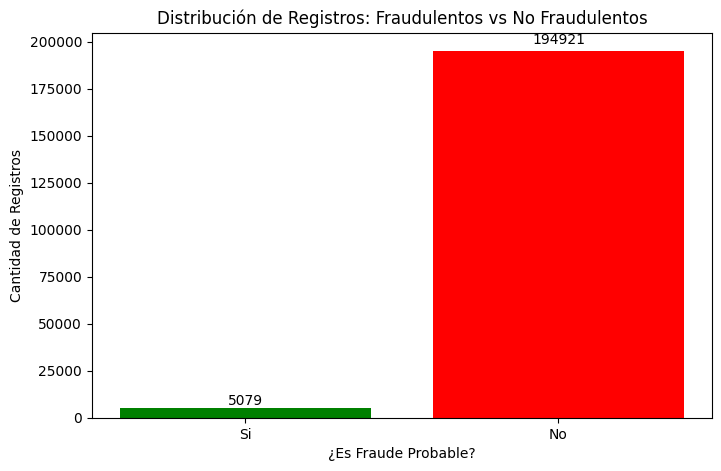

In [ ]:
import setuptools
from pyspark.sql.functions import count, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# 1. Calcular el total
total_registros_limpios = df_limpio.count()

# 2. Agrupación y Cálculos
df_fraude_summary = df_limpio.groupBy("fraude_probable", "es_fraude") \
    .agg(
        count("*").alias("Total_Registros"),
        (count("*") / total_registros_limpios * 100).alias("Porcentaje")
    ) \
    .orderBy(col("es_fraude").desc())

# 3. Convertir a Pandas (Aquí es donde daba el error antes)
pdf_fraude = df_fraude_summary.toPandas()

# 4. Graficar
plt.figure(figsize=(8, 5))
x_values = pdf_fraude['fraude_probable'].astype(str) 
bars = plt.bar(x_values, pdf_fraude['Total_Registros'], color=['green', 'red'])

plt.title('Distribución de Registros: Fraudulentos vs No Fraudulentos')
plt.xlabel('¿Es Fraude Probable?')
plt.ylabel('Cantidad de Registros')

# Añadir etiquetas de valor encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (yval*0.01), int(yval), ha='center', va='bottom')

plt.show()

--- 3.1. Tasa de Fraude por Tipo de Transacción ---


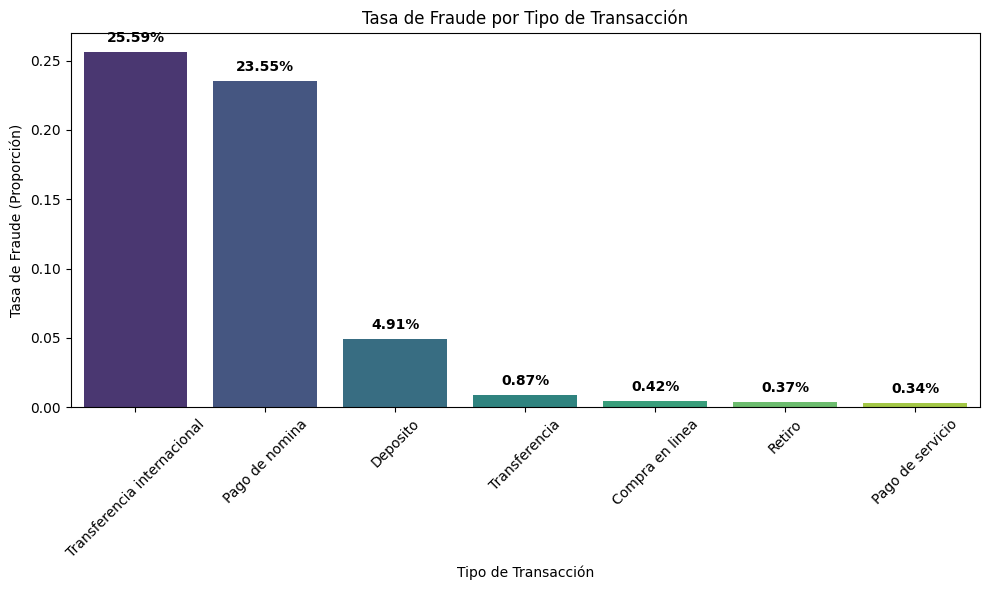

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- PARCHE OBLIGATORIO PARA PYTHON 3.12 ---
import setuptools
# -------------------------------------------

from pyspark.sql.functions import avg, col, count

print("--- 3.1. Tasa de Fraude por Tipo de Transacción ---")

# 1. Calcular agregados (Tasa de Fraude y Total de Transacciones)
df_tasa_fraude = df_limpio.groupBy("tipo_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc())

# 2. Convertir a Pandas
pdf_tasa = df_tasa_fraude.toPandas()

# 3. Graficar
plt.figure(figsize=(10, 6))

# Usamos 'hue' y 'legend=False' para evitar advertencias de Seaborn y mantener los colores
sns.barplot(
    data=pdf_tasa, 
    x='tipo_transaccion', 
    y='Tasa_Fraude', 
    palette='viridis', 
    hue='tipo_transaccion', 
    legend=False
)

plt.title('Tasa de Fraude por Tipo de Transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Tasa de Fraude (Proporción)')
plt.xticks(rotation=45)

# --- AJUSTE DE ESCALA (CORREGIDO) ---
# Ponemos el tope en 0.35 (35%) para hacer "zoom" en las barras.
# Como tu dato mayor es ~0.25, esto lo hará ver mucho mejor.
plt.ylim(0, 0.27)  
# ------------------------------------

# 4. Etiquetas de datos encima de las barras
for i, row in enumerate(pdf_tasa.itertuples()):
    # Ajustamos la posición vertical (+0.005) para que quede justo encima de la barra
    plt.text(
        i, 
        row.Tasa_Fraude + 0.005, 
        f"{row.Tasa_Fraude:.2%}", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

--- Distribución de Fraudes por Canal (Visualización Mejorada) ---


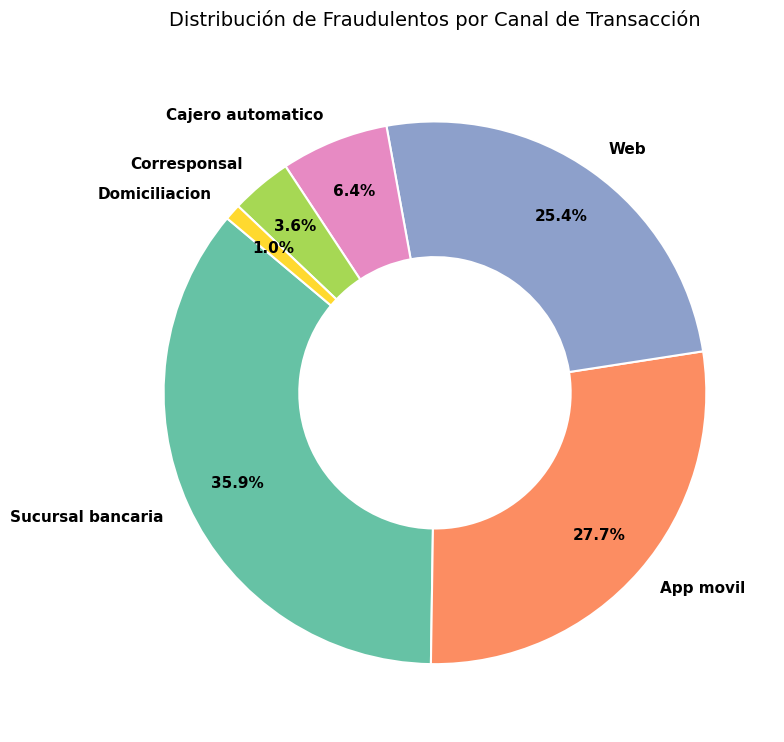

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools
from pyspark.sql.functions import col

print("--- Distribución de Fraudes por Canal (Visualización Mejorada) ---")

# 1. Filtrar y contar (igual que antes)
df_fraudes_por_canal = df_limpio.filter(col("es_fraude") == 1) \
    .groupBy("canal_transaccion") \
    .count() \
    .orderBy(col("count").desc())

# 2. Convertir a Pandas
pdf_fraudes_canal = df_fraudes_por_canal.toPandas()

# 3. Graficar (Estilo Dona Intenso)
plt.figure(figsize=(8, 9)) # Un poco más grande para que se aprecie el grosor

# --- CAMBIO 1: Paleta de colores intensos ---
# Usamos 'Set2' o 'bright' para colores más fuertes que los pastel
colors = sns.color_palette('Set2')[0:len(pdf_fraudes_canal)]

# Creamos el gráfico
plt.pie(
    pdf_fraudes_canal['count'],
    labels=pdf_fraudes_canal['canal_transaccion'],
    autopct='%1.1f%%',
    startangle=140,
    colors = colors,
    wedgeprops=dict(width=0.50, edgecolor='w', linewidth=1.5),
    # Ajustamos la posición del porcentaje para que quede bien centrado en el nuevo grosor
    pctdistance=0.80,
    textprops={'fontsize': 11, 'fontweight': 'bold'} # Etiquetas un poco más grandes y negritas
)

plt.title('Distribución de Fraudulentos por Canal de Transacción', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

In [ ]:
print("--- 3.2. Tasa de Fraude por Canal de Transacción ---")
df_limpio.groupBy("canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- 3.2. Tasa de Fraude por Canal de Transacción ---
+-----------------+--------------------+-------------------+
|canal_transaccion|         Tasa_Fraude|Total_Transacciones|
+-----------------+--------------------+-------------------+
|Sucursal bancaria| 0.07845670240709642|              23223|
|     Corresponsal| 0.04771730719628579|               3877|
|              Web|0.021446964033557604|              60195|
|        App movil|0.017993575551261215|              78139|
|Cajero automatico|0.016554946171033924|              19692|
|    Domiciliacion|0.003294339115234...|              14874|
+-----------------+--------------------+-------------------+



--- Distribución de Fraudes por Categoría (Visualización Mejorada) ---


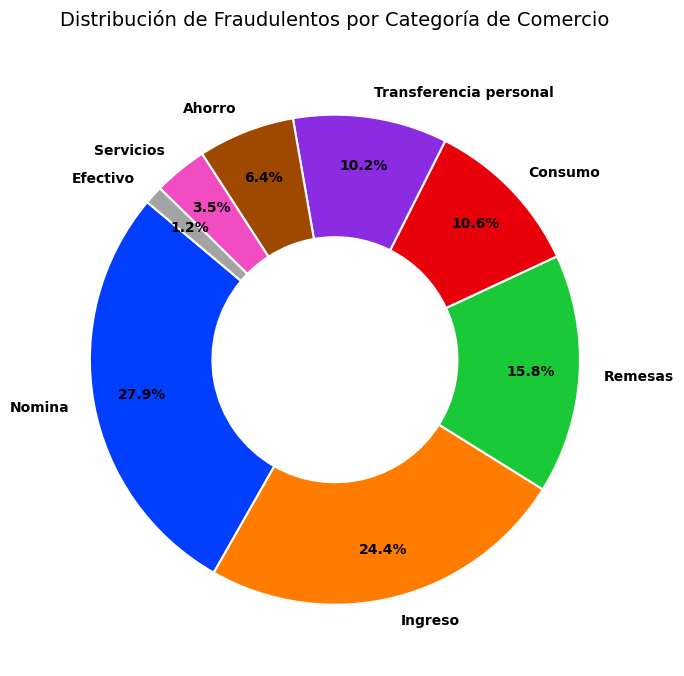

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools
# Asegúrate de tener importado 'col' si esta es una celda nueva
from pyspark.sql.functions import col

print("--- Distribución de Fraudes por Categoría (Visualización Mejorada) ---")

# 1. Filtrar solo transacciones fraudulentas y contar por categoría
df_fraudes_por_categoria = df_limpio.filter(col("es_fraude") == 1) \
    .groupBy("categoria") \
    .count() \
    .orderBy(col("count").desc())

# 2. Convertir a Pandas
pdf_fraudes_categoria = df_fraudes_por_categoria.toPandas()

# 3. Graficar
plt.figure(figsize=(7, 7))

colors = sns.color_palette('bright')[0:len(pdf_fraudes_categoria)]

plt.pie(
    pdf_fraudes_categoria['count'],
    labels=pdf_fraudes_categoria['categoria'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    # width=0.75: Anillo grueso, poco espacio blanco en el centro.
    # edgecolor='w', linewidth=1.5: Bordes blancos definidos para separar los colores fuertes.
    wedgeprops=dict(width=0.50, edgecolor='w', linewidth=1.5),
    pctdistance=0.80, # Centrar los porcentajes en el anillo grueso
    textprops={'fontweight': 'bold'} # Texto en negrita para que resalte sobre colores fuertes
)

plt.title('Distribución de Fraudulentos por Categoría de Comercio', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [ ]:
print("--- 3.3. Tasa de Fraude por Categoría de Comercio ---")
df_limpio.groupBy("categoria") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- 3.3. Tasa de Fraude por Categoría de Comercio ---
+--------------------+--------------------+-------------------+
|           categoria|         Tasa_Fraude|Total_Transacciones|
+--------------------+--------------------+-------------------+
|             Remesas| 0.25054602184087366|               3205|
|              Nomina| 0.23043124491456468|               6145|
|             Ingreso| 0.13174992011928852|               9389|
|              Ahorro| 0.05002315886984715|               6477|
|Transferencia per...|0.014324504045217777|              36092|
|             Consumo|0.006631381169333546|              81431|
|           Servicios|0.004482853086942445|              40153|
|            Efectivo|0.003624035538929156|              17108|
+--------------------+--------------------+-------------------+



--- Estatus de los fraudes de 'Pago de nómina' ---


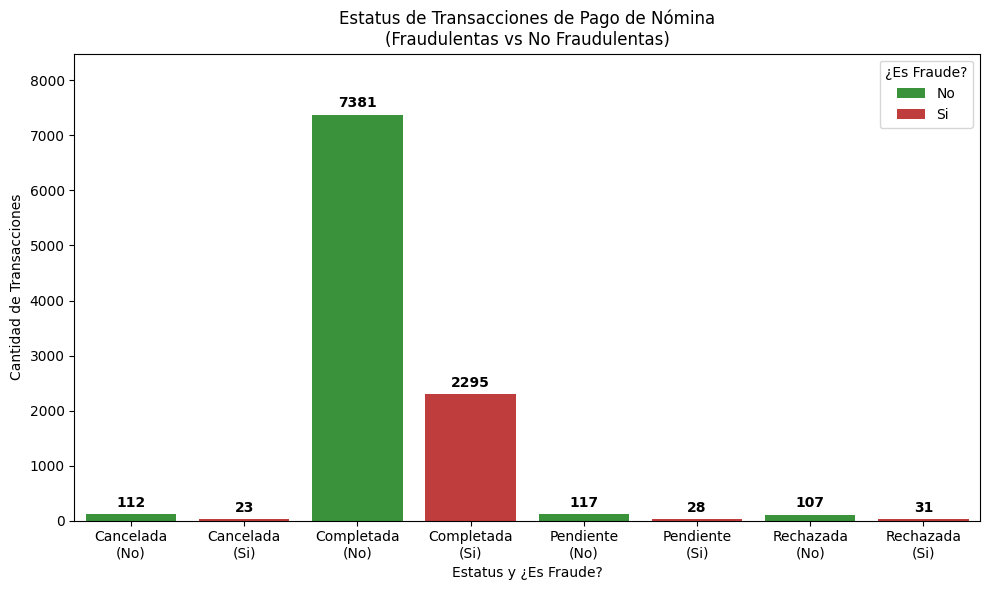

In [ ]:

print("--- Estatus de los fraudes de 'Pago de nómina' ---")

# 1. Generar los datos (Descomentamos y ajustamos la lógica)
# Filtramos por 'Pago de nomina' y agrupamos
df_estatus_nomina = df_limpio.filter(col("tipo_transaccion") == "Pago de nomina") \
    .groupBy("estatus", "es_fraude") \
    .count() \
    .orderBy("estatus", "es_fraude")

# 2. Convertir a Pandas
pdf_estatus = df_estatus_nomina.toPandas()

# 3. Preparación de datos para graficar
# Creamos una etiqueta legible para el fraude (0 -> No, 1 -> Si)
pdf_estatus['Fraude_Label'] = pdf_estatus['es_fraude'].apply(lambda x: 'Si' if x == 1 else 'No')

# Creamos la columna combinada asegurando que todo sea texto
# Ejemplo: "COMPLETADO - Si" o "FALLIDO - No"
pdf_estatus['Eje_X'] = pdf_estatus['estatus'].astype(str) + "\n(" + pdf_estatus['Fraude_Label'] + ")"

# 4. Graficar
plt.figure(figsize=(10, 6))

# Definimos colores manuales: Rojo para Fraude (Si), Verde para No Fraude (No)
colores = {'Si': '#d62728', 'No': '#2ca02c'} # Rojo y Verde intensos de Matplotlib

ax = sns.barplot(
    data=pdf_estatus, 
    x='Eje_X', 
    y='count', 
    hue='Fraude_Label', 
    palette=colores,
    dodge=False # Esto centra las barras en su categoría del eje X
)

plt.title('Estatus de Transacciones de Pago de Nómina\n(Fraudulentas vs No Fraudulentas)')
plt.xlabel('Estatus y ¿Es Fraude?')
plt.ylabel('Cantidad de Transacciones')

# Añadir etiquetas de valor automáticamente (Método robusto)
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=10, fontweight='bold')

# Ajustar margen superior para que quepan las etiquetas
plt.ylim(0, pdf_estatus['count'].max() * 1.15)

plt.legend(title='¿Es Fraude?')
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import col, avg, count

# PASO 1.A: Revisa los 'estatus' de esos fraudes de nómina
print("--- Estatus de los fraudes de 'Pago de nomina' ---")
df_limpio.filter(col("tipo_transaccion") == "Pago de nomina") \
    .groupBy("estatus", "fraude_probable") \
    .count() \
    .show()

# PASO 1.B: Re-calcula tu tasa SOLO para transacciones 'Completada'
print("--- Tasa de Fraude (Solo 'Completada') por Tipo ---")
df_completado = df_limpio.filter(col("estatus") == "Completada")

df_completado.groupBy("tipo_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show()

--- Estatus de los fraudes de 'Pago de nomina' ---
+----------+---------------+-----+
|   estatus|fraude_probable|count|
+----------+---------------+-----+
|Completada|             Si| 2295|
| Cancelada|             No|  112|
| Rechazada|             Si|   31|
| Rechazada|             No|  107|
| Cancelada|             Si|   23|
| Pendiente|             No|  117|
| Pendiente|             Si|   28|
|Completada|             No| 7381|
+----------+---------------+-----+

--- Tasa de Fraude (Solo 'Completada') por Tipo ---
+--------------------+--------------------+-------------------+
|    tipo_transaccion|         Tasa_Fraude|Total_Transacciones|
+--------------------+--------------------+-------------------+
|Transferencia int...|   0.252092050209205|               3824|
|      Pago de nomina|  0.2371847871021083|               9676|
|            Deposito|0.049024117763028195|              15217|
|       Transferencia|0.008637375902761878|              48047|
|     Compra en linea|0.0042

--- Tasa de Fraude (Solo 'Completada') por Tipo de Transacción ---


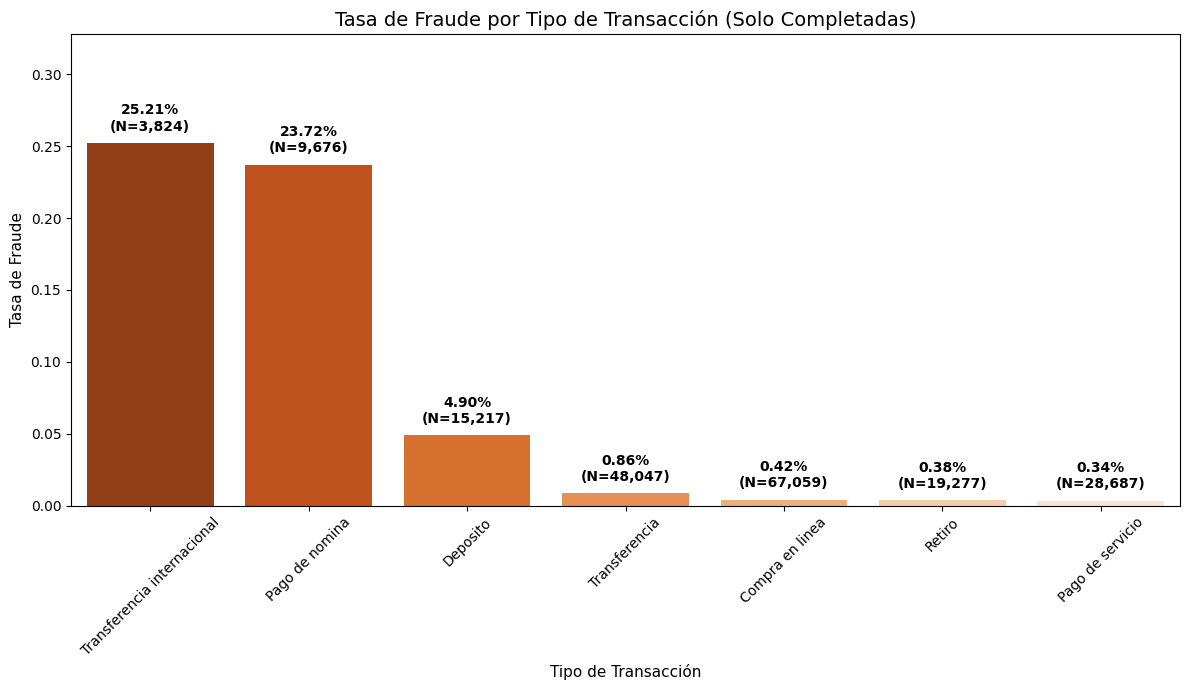

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools # Parche para Python 3.12
from pyspark.sql.functions import avg, col, count

print("--- Tasa de Fraude (Solo 'Completada') por Tipo de Transacción ---")

# 1. Filtrar y Calcular (Igual que antes)
df_completadas = df_limpio.filter(col("estatus") == "Completada")

df_tasa_completadas = df_completadas.groupBy("tipo_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc())

# 2. Convertir a Pandas
pdf_tasa_completadas = df_tasa_completadas.toPandas()

# 3. Graficar
plt.figure(figsize=(12, 7)) # Un poco más ancho para que los textos no choquen entre sí

sns.barplot(
    data=pdf_tasa_completadas, 
    x='tipo_transaccion', 
    y='Tasa_Fraude', 
    palette='Oranges_r', # Usé 'Oranges_r' (reverse) para que las barras altas sean las oscuras (opcional)
    hue='tipo_transaccion', 
    legend=False
)

plt.title('Tasa de Fraude por Tipo de Transacción (Solo Completadas)', fontsize=14)
plt.xlabel('Tipo de Transacción', fontsize=11)
plt.ylabel('Tasa de Fraude', fontsize=11)
plt.xticks(rotation=45)

# --- AJUSTE DE ESCALA (CRÍTICO) ---
# Damos más espacio arriba (30% extra) porque ahora la etiqueta es de dos líneas
top_limit = pdf_tasa_completadas['Tasa_Fraude'].max() * 1.30
plt.ylim(0, top_limit)

# --- ETIQUETAS UNIFICADAS ---
# Ponemos todo arriba: Porcentaje en negrita y abajo (N=...) en normal
for i, row in enumerate(pdf_tasa_completadas.itertuples()):
    # Creamos un texto de dos líneas con \n
    label_text = f"{row.Tasa_Fraude:.2%}\n(N={row.Total_Transacciones:,})"
    
    plt.text(
        i, 
        row.Tasa_Fraude + (top_limit * 0.02), # Un poquito arriba de la barra
        label_text, 
        ha='center', 
        va='bottom', 
        fontsize=10,
        color='black',
        fontweight='bold' # Opcional: poner todo en negrita o solo una parte
    )

plt.tight_layout()
plt.show()

In [ ]:
# Agregar columna de porcentaje formateada
pdf_tasa_completadas['Porcentaje'] = pdf_tasa_completadas['Tasa_Fraude'].apply(lambda x: f"{x:.2%}")

# Agregar separador de miles a las transacciones para que sea más legible
pdf_tasa_completadas['Total_Fmt'] = pdf_tasa_completadas['Total_Transacciones'].apply(lambda x: f"{x:,}")

print("\n--- Resumen: Tasa de Fraude por Tipo (Solo Completadas) ---")

# Seleccionamos las columnas y usamos display() para una tabla bonita
display(pdf_tasa_completadas[['tipo_transaccion', 'Porcentaje', 'Total_Fmt']])


--- Resumen: Tasa de Fraude por Tipo (Solo Completadas) ---


,tipo_transaccion,Porcentaje,Total_Fmt
0,Transferencia internacional,25.21%,"3,824"
1,Pago de nomina,23.72%,"9,676"
2,Deposito,4.90%,"15,217"
3,Transferencia,0.86%,"48,047"
4,Compra en linea,0.42%,"67,059"
5,Retiro,0.38%,"19,277"
6,Pago de servicio,0.34%,"28,687"


In [ ]:
from pyspark.sql.functions import stddev, min, max

print("--- Análisis de Monto por Fraude (1 = Fraude) ---")
df_limpio.groupBy("es_fraude") \
    .agg(
        avg("monto").alias("monto_promedio"),
        stddev("monto").alias("monto_stddev"),
        min("monto").alias("monto_min"),
        max("monto").alias("monto_max")
    ) \
    .show()

--- Análisis de Monto por Fraude (1 = Fraude) ---
+---------+------------------+------------------+---------+---------+
|es_fraude|    monto_promedio|      monto_stddev|monto_min|monto_max|
+---------+------------------+------------------+---------+---------+
|        1|44318.581549517636|29159.361048703613|  1545.85| 99998.74|
|        0|  936.307703992898|1711.1324412832882|     50.0| 14966.01|
+---------+------------------+------------------+---------+---------+



In [ ]:
from pyspark.sql.functions import hour

# 1. Crear la columna 'hora_del_dia' (asumo que tu schema la tiene)
df_con_hora = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento")))

# 2. Analizar tasa de fraude por hora
print("--- Tasa de Fraude por Hora del Día ---")
df_con_hora.groupBy("hora_del_dia") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy("hora_del_dia") \
    .show(24) # Mostrar las 24 horas

--- Tasa de Fraude por Hora del Día ---


+------------+--------------------+-------------------+
|hora_del_dia|         Tasa_Fraude|Total_Transacciones|
+------------+--------------------+-------------------+
|           0| 0.17490890161374284|               1921|
|           1| 0.18577866800200302|               1997|
|           2| 0.17894736842105263|               1995|
|           3| 0.16557624559637646|               1987|
|           4| 0.17700453857791226|               1983|
|           5| 0.15919395465994962|               1985|
|           6|                 0.0|               1677|
|           7|                 0.0|               1631|
|           8|                 0.0|               1622|
|           9| 0.03135444851185739|               6283|
|          10|0.019301470588235295|              10880|
|          11|0.013756260434056762|              14975|
|          12|0.009130789634768415|              19604|
|          13|0.007791666666666666|              24000|
|          14|0.007483040772081964|             

--- Análisis Visual: Tasa de Fraude por Hora del Día ---


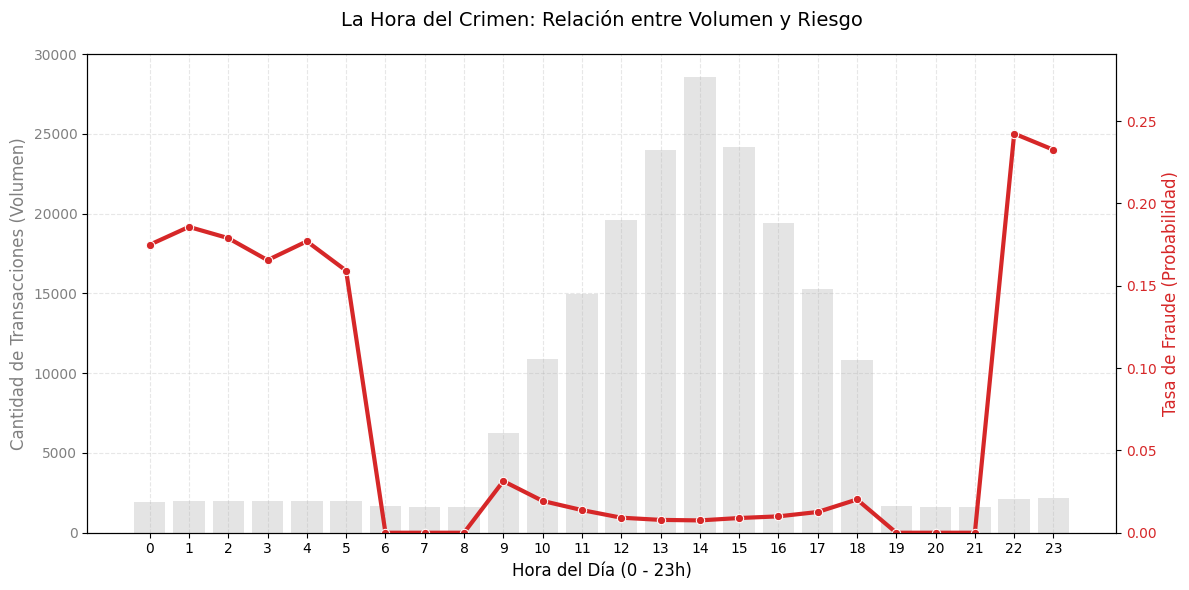

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools # Parche para Python 3.12 por si acaso

# 1. Importar TODAS las funciones necesarias de Spark
from pyspark.sql.functions import hour, col, avg, count

print("--- Análisis Visual: Tasa de Fraude por Hora del Día ---")

# 2. Transformación en Spark (Tu lógica)
# Extraemos la hora de la columna 'hora_movimiento'
df_con_hora = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento")))

# Agrupamos por hora para obtener Tasa de Fraude y Volumen
df_hora_summary = df_con_hora.groupBy("hora_del_dia") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy("hora_del_dia")

# 3. Convertir a Pandas para graficar
pdf_hora = df_hora_summary.toPandas()

# 4. Graficar (Gráfico de Doble Eje)
if not pdf_hora.empty:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # --- EJE IZQUIERDO (Barras Grises): Volumen de Transacciones ---
    sns.barplot(
        data=pdf_hora, 
        x='hora_del_dia', 
        y='Total_Transacciones', 
        color='lightgray', 
        alpha=0.6, # Transparencia para que no tape la línea
        ax=ax1
    )
    ax1.set_ylabel('Cantidad de Transacciones (Volumen)', color='gray', fontsize=12)
    ax1.set_xlabel('Hora del Día (0 - 23h)', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='gray')

    # --- EJE DERECHO (Línea Roja): Tasa de Fraude ---
    ax2 = ax1.twinx() # Crea un eje gemelo que comparte el mismo eje X
    sns.lineplot(
        data=pdf_hora, 
        x='hora_del_dia', 
        y='Tasa_Fraude', 
        marker='o', 
        color='#d62728', # Rojo intenso
        linewidth=3,
        ax=ax2
    )
    ax2.set_ylabel('Tasa de Fraude (Probabilidad)', color='#d62728', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#d62728')
    
    # Ajustamos la escala del eje rojo para que la línea no toque el techo
    # Damos un 20% de aire extra arriba del valor máximo
    max_tasa = pdf_hora['Tasa_Fraude'].max()
    ax2.set_ylim(0, max_tasa * 1.20)

    # 5. Detalles Finales
    plt.title('La Hora del Crimen: Relación entre Volumen y Riesgo', fontsize=14, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ El DataFrame está vacío. Revisa que la columna 'hora_movimiento' tenga datos válidos.")

--- Análisis Visual: Monto Promedio (Fraude vs No Fraude) ---


/tmp/ipykernel_22659/3790247420.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


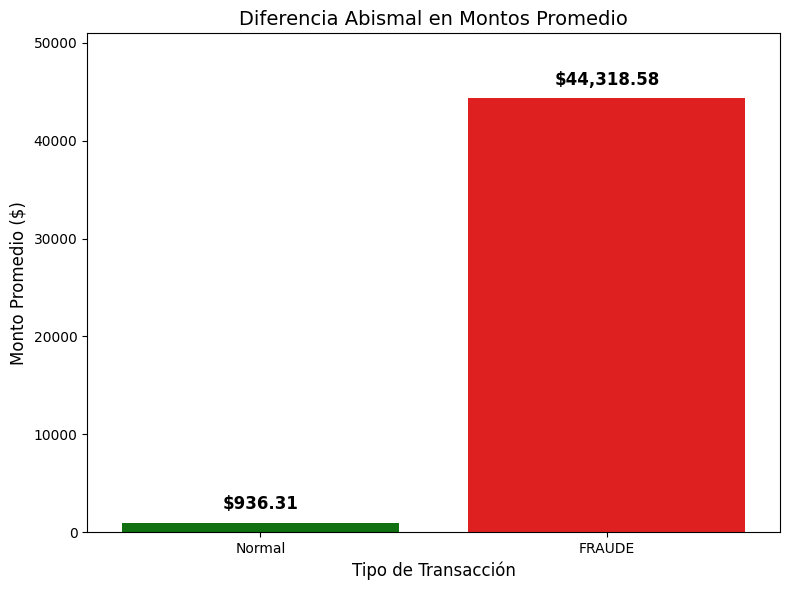

In [ ]:
print("--- Análisis Visual: Monto Promedio (Fraude vs No Fraude) ---")

# 1. Agrupar (Usando tu consulta de la imagen 2)
df_monto_summary = df_limpio.groupBy("es_fraude") \
    .agg(
        avg("monto").alias("monto_promedio")
    ) \
    .orderBy("es_fraude")

# 2. Convertir a Pandas
pdf_monto = df_monto_summary.toPandas()

# Etiquetas legibles
pdf_monto['Etiqueta'] = pdf_monto['es_fraude'].apply(lambda x: 'FRAUDE' if x == 1 else 'Normal')

# 3. Graficar
plt.figure(figsize=(8, 6))

barplot = sns.barplot(
    data=pdf_monto, 
    x='Etiqueta', 
    y='monto_promedio', 
    palette=['green', 'red'] # Verde para normal, Rojo para fraude
)

plt.title('Diferencia Abismal en Montos Promedio', fontsize=14)
plt.ylabel('Monto Promedio ($)', fontsize=12)
plt.xlabel('Tipo de Transacción', fontsize=12)

# 4. Poner los valores exactos encima (Formato Moneda)
for i, row in enumerate(pdf_monto.itertuples()):
    plt.text(
        i, 
        row.monto_promedio + 1000, 
        f"${row.monto_promedio:,.2f}", # Formato de dinero con comas y 2 decimales
        ha='center', 
        va='bottom', 
        fontsize=12, 
        fontweight='bold',
        color='black'
    )

# Ampliar un poco el techo del gráfico para que quepa el texto del fraude
plt.ylim(0, pdf_monto['monto_promedio'].max() * 1.15)

plt.tight_layout()
plt.show()

In [ ]:
print("--- Interacción: Tipo de Transacción vs. Canal ---")
df_limpio.groupBy("tipo_transaccion", "canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show(truncate=False) # truncate=False para ver los nombres completos

--- Interacción: Tipo de Transacción vs. Canal ---
+---------------------------+-----------------+---------------------+-------------------+
|tipo_transaccion           |canal_transaccion|Tasa_Fraude          |Total_Transacciones|
+---------------------------+-----------------+---------------------+-------------------+
|Transferencia internacional|Sucursal bancaria|0.2577276524644946   |2394               |
|Transferencia internacional|Web              |0.25314070351758794  |1592               |
|Pago de nomina             |App movil        |0.23604622571920333  |4067               |
|Pago de nomina             |Web              |0.2355958958168903   |2534               |
|Pago de nomina             |Sucursal bancaria|0.23475522473518465  |3493               |
|Deposito                   |Sucursal bancaria|0.04972549019607843  |6375               |
|Deposito                   |Cajero automatico|0.04937163375224417  |5570               |
|Deposito                   |Corresponsal     |0.

--- 4. Mapa de Calor: Interacción Tipo vs. Canal (Tamaño Ajustado) ---


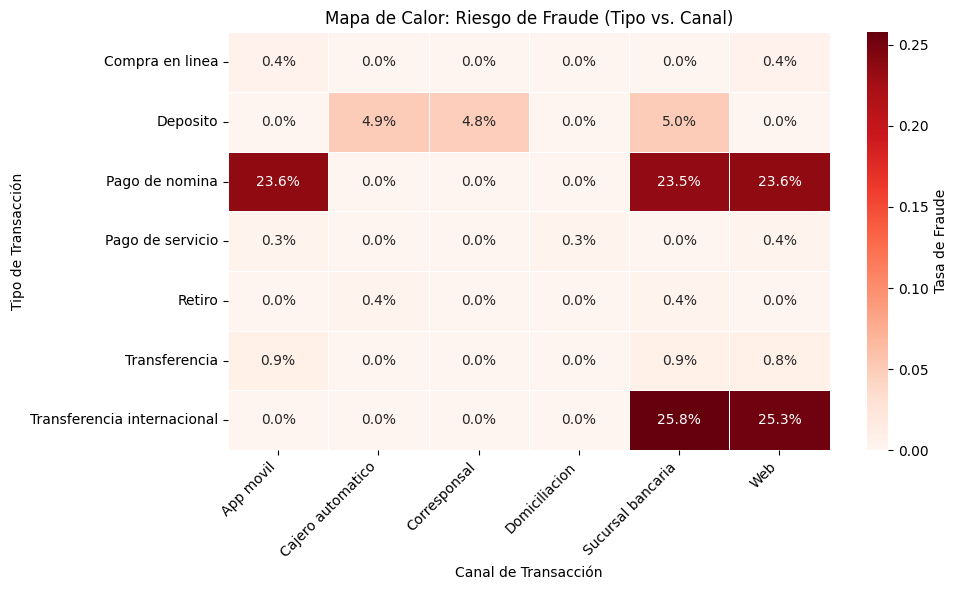

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import setuptools
from pyspark.sql.functions import avg, col, count

print("--- 4. Mapa de Calor: Interacción Tipo vs. Canal (Tamaño Ajustado) ---")

# 1. Generar la tabla cruzada
df_interaccion = df_limpio.groupBy("tipo_transaccion", "canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude")
    )

# 2. Convertir a Pandas
pdf_interaccion = df_interaccion.toPandas()

# 3. Preparar los datos (Pivotear)
matriz_fraude = pdf_interaccion.pivot(
    index='tipo_transaccion', 
    columns='canal_transaccion', 
    values='Tasa_Fraude'
).fillna(0)

# 4. Graficar
# --- CAMBIO DE TAMAÑO ---
# Reducimos de (12, 8) a (10, 6) para que sea más compacto.
plt.figure(figsize=(10, 6)) 
# ------------------------

ax = sns.heatmap(
    matriz_fraude, 
    annot=True, 
    fmt=".1%", 
    cmap="Reds", 
    linewidths=.5,
    cbar_kws={'label': 'Tasa de Fraude'}
)

plt.title('Mapa de Calor: Riesgo de Fraude (Tipo vs. Canal)', fontsize=12)
plt.xlabel('Canal de Transacción', fontsize=10)
plt.ylabel('Tipo de Transacción', fontsize=10)
plt.xticks(rotation=45, ha='right') # Rotamos un poco las etiquetas del eje X para que no choquen
plt.tight_layout()
plt.show()
plt.show()

In [ ]:
from pyspark.sql.functions import col, avg, count, when, hour

# --- 1. Asegúrate de tener las 'features' de hora y monto ---
df_con_features = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento"))) \
                            .withColumn("es_monto_alto", 
                                when(col("monto") > 1500, 1).otherwise(0) # Usamos 1500 como umbral (basado en tu min_fraude)
                            )

print("--- Interacción: Tipo vs. Hora vs. Monto ---")
df_con_features.groupBy(
    "tipo_transaccion", 
    "hora_del_dia", 
    "es_monto_alto"
).agg(
    avg("es_fraude").alias("Tasa_Fraude"),
    count("*").alias("Total_Transacciones")
).orderBy(col("Tasa_Fraude").desc()) \
 .show(truncate=False)

--- Interacción: Tipo vs. Hora vs. Monto ---


+----------------+------------+-------------+-----------+-------------------+
|tipo_transaccion|hora_del_dia|es_monto_alto|Tasa_Fraude|Total_Transacciones|
+----------------+------------+-------------+-----------+-------------------+
|Retiro          |9           |1            |1.0        |5                  |
|Retiro          |1           |1            |1.0        |6                  |
|Compra en linea |3           |1            |1.0        |21                 |
|Compra en linea |14          |1            |1.0        |17                 |
|Compra en linea |23          |1            |1.0        |23                 |
|Compra en linea |22          |1            |1.0        |31                 |
|Compra en linea |1           |1            |1.0        |17                 |
|Pago de servicio|5           |1            |1.0        |7                  |
|Compra en linea |4           |1            |1.0        |18                 |
|Compra en linea |5           |1            |1.0        |19     

In [ ]:
print("--- 4. Tasa de Fraude Cruzada: Tipo vs. Canal ---")

# Agrupar por AMBAS columnas
df_limpio.groupBy("tipo_transaccion", "canal_transaccion") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("Tasa_Fraude").desc()) \
    .show(50, truncate=False) # Mostramos más filas y sin truncar

--- 4. Tasa de Fraude Cruzada: Tipo vs. Canal ---


+---------------------------+-----------------+---------------------+-------------------+
|tipo_transaccion           |canal_transaccion|Tasa_Fraude          |Total_Transacciones|
+---------------------------+-----------------+---------------------+-------------------+
|Transferencia internacional|Sucursal bancaria|0.2577276524644946   |2394               |
|Transferencia internacional|Web              |0.25314070351758794  |1592               |
|Pago de nomina             |App movil        |0.23604622571920333  |4067               |
|Pago de nomina             |Web              |0.2355958958168903   |2534               |
|Pago de nomina             |Sucursal bancaria|0.23475522473518465  |3493               |
|Deposito                   |Sucursal bancaria|0.04972549019607843  |6375               |
|Deposito                   |Cajero automatico|0.04937163375224417  |5570               |
|Deposito                   |Corresponsal     |0.04771730719628579  |3877               |
|Transfere

In [ ]:
from pyspark.sql.functions import hour, to_date

df_con_tiempo = df_limpio.withColumn("fecha_dt", to_date(col("fecha")))
df_con_tiempo = df_con_tiempo.withColumn("hora_del_dia", hour(col("hora_movimiento")))


print("--- 5. Tasa de Fraude por Hora del Día ---")
df_con_tiempo.groupBy("hora_del_dia") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy(col("hora_del_dia")) \
    .show(24)

--- 5. Tasa de Fraude por Hora del Día ---
+------------+--------------------+-------------------+
|hora_del_dia|         Tasa_Fraude|Total_Transacciones|
+------------+--------------------+-------------------+
|           0| 0.17490890161374284|               1921|
|           1| 0.18577866800200302|               1997|
|           2| 0.17894736842105263|               1995|
|           3| 0.16557624559637646|               1987|
|           4| 0.17700453857791226|               1983|
|           5| 0.15919395465994962|               1985|
|           6|                 0.0|               1677|
|           7|                 0.0|               1631|
|           8|                 0.0|               1622|
|           9| 0.03135444851185739|               6283|
|          10|0.019301470588235295|              10880|
|          11|0.013756260434056762|              14975|
|          12|0.009130789634768415|              19604|
|          13|0.007791666666666666|              24000|
|    

In [ ]:
from pyspark.sql.functions import when, col

# --- 1. Crear las "banderas" de riesgo ---
df_con_banderas = df_con_tiempo.withColumn("es_horario_riesgo", 
        when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
    ).withColumn("es_tipo_riesgo", 
        when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
    ).withColumn("es_canal_riesgo", 
        when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
    )

# --- 2. Consulta de Validación Final ---
# Queremos ver si TODAS las transacciones de fraude (es_fraude == 1)
# tienen TODAS las banderas de riesgo en 1. 
print("--- 6. Validación Final de Reglas de Fraude ---")
df_con_banderas.groupBy(
    "es_fraude", 
    "es_horario_riesgo", 
    "es_tipo_riesgo",
    "es_canal_riesgo"
).agg(
    count("*").alias("Total_Transacciones")
).orderBy(col("es_fraude").desc(), col("Total_Transacciones").desc()) \
 .show()

--- 6. Validación Final de Reglas de Fraude ---


+---------+-----------------+--------------+---------------+-------------------+
|es_fraude|es_horario_riesgo|es_tipo_riesgo|es_canal_riesgo|Total_Transacciones|
+---------+-----------------+--------------+---------------+-------------------+
|        1|                0|             0|              1|               2038|
|        1|                1|             0|              1|               1025|
|        1|                0|             1|              1|                938|
|        1|                1|             1|              1|                518|
|        1|                0|             0|              0|                359|
|        1|                1|             0|              0|                201|
|        0|                0|             0|              1|             100039|
|        0|                0|             1|              1|              50474|
|        0|                0|             0|              0|              36269|
|        0|                1

--- Validación del Modelo de Reglas ---


/tmp/ipykernel_22659/4036046842.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


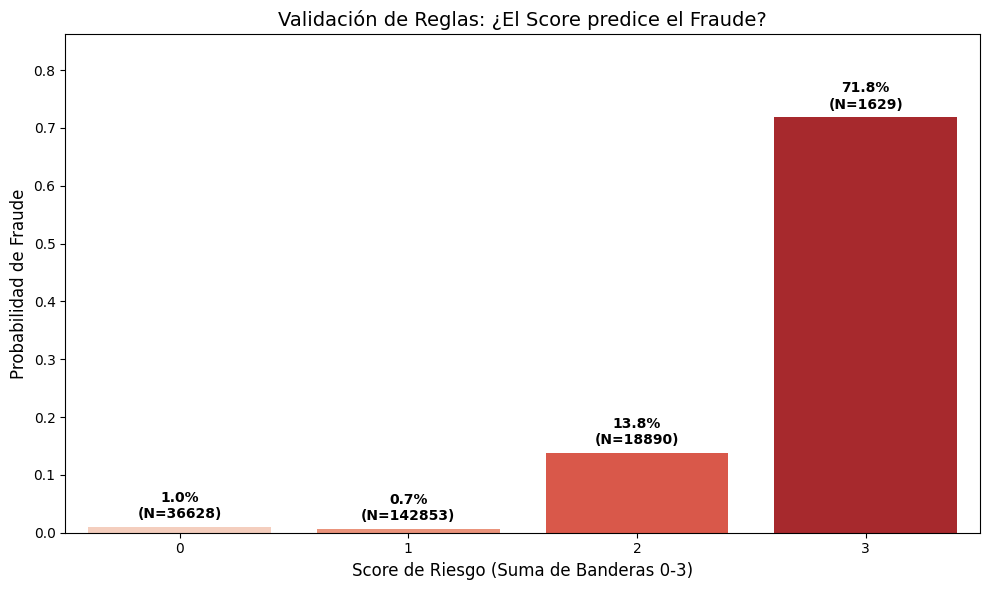

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when, col, count, avg

# --- 1. Definir las banderas (Asegúrate de usar el DF correcto, ej: df_con_hora) ---
df_con_banderas = df_con_hora.withColumn("es_horario_riesgo", 
        when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
    ).withColumn("es_tipo_riesgo", 
        when(col("tipo_transaccion").isin("Transferencia internacional", "Pago de nomina"), 1).otherwise(0)
    ).withColumn("es_canal_riesgo", 
        when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
    )

# --- 2. CREAR EL SCORE (La suma de las banderas) ---
# 0 = Seguro, 3 = Peligro Extremo
df_scoring = df_con_banderas.withColumn("Score_Riesgo", 
    col("es_horario_riesgo") + col("es_tipo_riesgo") + col("es_canal_riesgo")
)

# --- 3. Análisis: Tasa de Fraude por Score ---
print("--- Validación del Modelo de Reglas ---")
df_score_summary = df_scoring.groupBy("Score_Riesgo") \
    .agg(
        avg("es_fraude").alias("Tasa_Fraude"),
        count("*").alias("Total_Transacciones")
    ) \
    .orderBy("Score_Riesgo")

# 4. Convertir a Pandas y Graficar
pdf_score = df_score_summary.toPandas()

# --- GRAFICAR EL PODER PREDICTIVO ---
plt.figure(figsize=(10, 6))

# Usamos un mapa de colores que vaya de Verde (Score 0) a Rojo Intenso (Score 3)
sns.barplot(
    data=pdf_score, 
    x='Score_Riesgo', 
    y='Tasa_Fraude', 
    palette='Reds' 
)

plt.title('Validación de Reglas: ¿El Score predice el Fraude?', fontsize=14)
plt.xlabel('Score de Riesgo (Suma de Banderas 0-3)', fontsize=12)
plt.ylabel('Probabilidad de Fraude', fontsize=12)

# Etiquetas de valor
for i, row in enumerate(pdf_score.itertuples()):
    plt.text(
        i, 
        row.Tasa_Fraude + 0.01, 
        f"{row.Tasa_Fraude:.1%}\n(N={row.Total_Transacciones})", 
        ha='center', 
        va='bottom', 
        fontweight='bold'
    )

plt.ylim(0, pdf_score['Tasa_Fraude'].max() * 1.2)
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

print("--- Entrenando Modelo de Machine Learning (Logistic Regression) ---")

# 1. PREPARACIÓN DE DATOS (Feature Engineering)
# Seleccionamos las variables numéricas que ya demostraron ser útiles
# Usamos las banderas que creaste, más el monto y la hora
columnas_input = [
    "monto", 
    "hora_del_dia", 
    "es_horario_riesgo", 
    "es_tipo_riesgo", 
    "es_canal_riesgo"
]

# Spark ML necesita que todas las variables entren en una sola columna tipo "Vector"
assembler = VectorAssembler(inputCols=columnas_input, outputCol="features")
data_ml = assembler.transform(df_con_banderas)

# Seleccionamos solo las features y el objetivo (label)
data_final = data_ml.select("features", col("es_fraude").alias("label"))

# 2. DIVIDIR DATOS (Train / Test)
# Usamos 70% para entrenar y 30% para examen final
train_data, test_data = data_final.randomSplit([0.7, 0.3], seed=42)

# 3. ENTRENAR EL MODELO
# Regresión Logística: El algoritmo clásico para predecir Sí/No
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
modelo_lr = lr.fit(train_data)

# 4. EVALUAR (El Examen)
predicciones = modelo_lr.transform(test_data)

# Usamos el área bajo la curva (AUC) para calificar al modelo (1.0 es perfecto, 0.5 es suerte)
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predicciones)

print(f"¡Modelo Entrenado!")
print(f"Precisión del Modelo (AUC): {auc:.2f}")

# Ver qué coeficientes (pesos) le dio a cada variable
print("\n--- Importancia de las Variables ---")
print(f"Intercepto (Base): {modelo_lr.intercept:.4f}")
for i, col_name in enumerate(columnas_input):
    print(f"{col_name}: {modelo_lr.coefficients[i]:.4f}")

--- Entrenando Modelo de Machine Learning (Logistic Regression) ---


25/11/30 23:30:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/30 23:30:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


¡Modelo Entrenado!
Precisión del Modelo (AUC): 0.99

--- Importancia de las Variables ---
Intercepto (Base): -11.1393
monto: 0.0006
hora_del_dia: 0.2455
es_horario_riesgo: 5.7884
es_tipo_riesgo: -1.5466
es_canal_riesgo: -0.5928


In [ ]:
# Necesitamos instalar esta librería pequeña para dibujar los círculos
%pip install matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


--- Generando Diagrama de Venn de los Fraudes ---


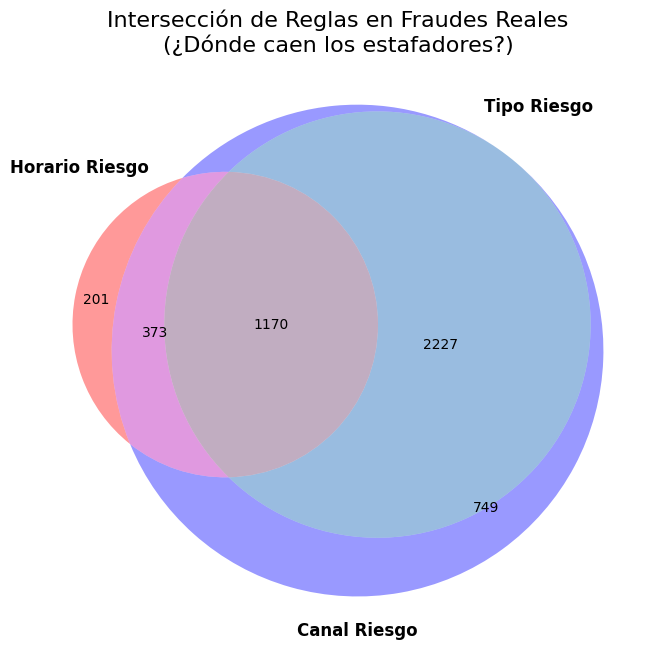

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from pyspark.sql.functions import col

print("--- Generando Diagrama de Venn de los Fraudes ---")

# 1. PREPARAR DATOS
# Filtramos solo los Fraudes Reales (es_fraude == 1) para ver cómo se comportan
df_venn = df_con_banderas.filter(col("es_fraude") == 1) \
    .select("es_horario_riesgo", "es_tipo_riesgo", "es_canal_riesgo")

# Agrupamos para contar cuántos fraudes hay en cada combinación exacta
# Ejemplo: Cuántos tienen Horario(1) + Tipo(0) + Canal(1)
conteo = df_venn.groupBy("es_horario_riesgo", "es_tipo_riesgo", "es_canal_riesgo").count().collect()

# 2. PROCESAR PARA EL GRÁFICO
# Necesitamos llenar un diccionario con las 7 combinaciones posibles para el Venn
# Clave: (Horario, Tipo, Canal) -> Valor: Cantidad
conteos_dict = {}

for row in conteo:
    # La clave será una tupla (1, 0, 1) etc.
    clave = (row['es_horario_riesgo'], row['es_tipo_riesgo'], row['es_canal_riesgo'])
    conteos_dict[clave] = row['count']

# Función auxiliar para sacar el valor de forma segura (si no hay datos pone 0)
def get_c(h, t, c):
    return conteos_dict.get((h, t, c), 0)

# 3. GRAFICAR
plt.figure(figsize=(8, 8))

# La función venn3 pide los tamaños de los subconjuntos en un orden específico:
# (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# A = Horario, B = Tipo, C = Canal
out = venn3(subsets=(
        get_c(1, 0, 0), # Solo Horario (A)
        get_c(0, 1, 0), # Solo Tipo (B)
        get_c(1, 1, 0), # Horario + Tipo
        get_c(0, 0, 1), # Solo Canal (C)
        get_c(1, 0, 1), # Horario + Canal
        get_c(0, 1, 1), # Tipo + Canal
        get_c(1, 1, 1)  # LOS TRES (La zona de máximo riesgo)
    ),
    set_labels=('Horario Riesgo', 'Tipo Riesgo', 'Canal Riesgo')
)

# Estilizando un poco para que se vea profesional
# Cambiamos colores de las etiquetas
for text in out.set_labels:
    text.set_fontsize(12)
    text.set_fontweight('bold')

plt.title("Intersección de Reglas en Fraudes Reales\n(¿Dónde caen los estafadores?)", fontsize=16)
plt.show()

In [ ]:
from pyspark.sql.functions import col, when, hour

# --- 1. Feature de Horario de Riesgo ---
df_features = df_con_tiempo.withColumn("feat_horario_riesgo", 
    when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
)

In [ ]:
# --- 2. Feature de Tipo de Transacción de Riesgo ---
df_features = df_features.withColumn("feat_tipo_riesgo", 
    when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
)

In [ ]:
# --- 3. Feature de Canal de Riesgo ---
df_features = df_features.withColumn("feat_canal_riesgo", 
    when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
)

In [ ]:
df_features = df_features.withColumn("feat_perfil_riesgo_completo", 
    when((col("feat_horario_riesgo") == 1) & 
         (col("feat_tipo_riesgo") == 1) & 
         (col("feat_canal_riesgo") == 1), 1).otherwise(0)
)

In [ ]:
from pyspark.sql.functions import avg, log

# --- 5. Feature Log(Monto) ---
# (Sumamos 1 para evitar errores si el monto es 0)
df_features = df_features.withColumn("feat_log_monto", log(col("monto") + 1))

In [ ]:
# --- 6. Feature de Ratio del Monto ---
promedios_tipo = df_features.groupBy("tipo_transaccion") \
    .agg(avg("monto").alias("monto_promedio_tipo"))

In [ ]:
# 2. Unimos (join) estos promedios de vuelta a nuestro DataFrame principal
df_features = df_features.join(promedios_tipo, on="tipo_transaccion", how="left")


In [ ]:
# 3. Creamos el ratio (Monto / Monto Promedio del Tipo)
#    (Manejamos división por cero por si acaso)
df_features = df_features.withColumn("feat_ratio_monto_vs_tipo", 
    when(col("monto_promedio_tipo") > 0, col("monto") / col("monto_promedio_tipo")) \
    .otherwise(0)
)

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# --- 7. Codificación Categórica ---
# Lista de columnas categóricas que queremos usar
columnas_categoricas = ["canal_transaccion", "tipo_transaccion", "categoria", "divisa", "ciudad", "medio_pago"]

# Nombres de salida para las columnas indexadas
columnas_indexadas = [c + "_idx" for c in columnas_categoricas]

# Nombres de salida para las columnas codificadas (One-Hot)
columnas_onehot = [c + "_ohe" for c in columnas_categoricas]

# 1. Crear el StringIndexer
indexer = StringIndexer(inputCols=columnas_categoricas, outputCols=columnas_indexadas)

# 2. Crear el OneHotEncoder
encoder = OneHotEncoder(inputCols=columnas_indexadas, outputCols=columnas_onehot)


In [ ]:
from pyspark.sql.functions import col, when, hour, avg, log

# --- 0. Asegúrate de tener las columnas de tiempo ---
# (Esto asume que 'df_limpio' existe)
df_con_tiempo = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento")))

# --- 1. Crear Banderas de Riesgo ---
df_features = df_con_tiempo.withColumn("feat_horario_riesgo", 
    when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
).withColumn("feat_tipo_riesgo", 
    when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
).withColumn("feat_canal_riesgo", 
    when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
)

# --- 2. Crear "Golden Feature" (Interacción) ---
df_features = df_features.withColumn("feat_perfil_riesgo_completo", 
    when((col("feat_horario_riesgo") == 1) & 
         (col("feat_tipo_riesgo") == 1) & 
         (col("feat_canal_riesgo") == 1), 1).otherwise(0)
)

# --- 3. Features de Monto (Log y Ratio) ---
df_features = df_features.withColumn("feat_log_monto", log(col("monto") + 1))

# 3.1 Calcular promedios por tipo
promedios_tipo = df_features.groupBy("tipo_transaccion") \
    .agg(avg("monto").alias("monto_promedio_tipo"))

# 3.2 Unir (join) los promedios
df_features = df_features.join(promedios_tipo, on="tipo_transaccion", how="left")

# 3.3 Crear el ratio
df_features = df_features.withColumn("feat_ratio_monto_vs_tipo", 
    when(col("monto_promedio_tipo") > 0, col("monto") / col("monto_promedio_tipo")) \
    .otherwise(0)
)


# --- 4. MOSTRAR LOS CAMBIOS ---
# Seleccionamos algunas columnas originales Y todas las nuevas 'feat_'
print("DataFrame con las nuevas características:")
df_features.select(
    "es_fraude",
    "monto",
    "hora_del_dia",
    "tipo_transaccion",
    "canal_transaccion",
    "feat_horario_riesgo",     # Nueva
    "feat_tipo_riesgo",        # Nueva
    "feat_canal_riesgo",       # Nueva
    "feat_perfil_riesgo_completo", # Nueva
    "feat_log_monto",          # Nueva
    "feat_ratio_monto_vs_tipo" # Nueva
).show()

DataFrame con las nuevas características:
+---------+--------+------------+----------------+-----------------+-------------------+----------------+-----------------+---------------------------+------------------+------------------------+
|es_fraude|   monto|hora_del_dia|tipo_transaccion|canal_transaccion|feat_horario_riesgo|feat_tipo_riesgo|feat_canal_riesgo|feat_perfil_riesgo_completo|    feat_log_monto|feat_ratio_monto_vs_tipo|
+---------+--------+------------+----------------+-----------------+-------------------+----------------+-----------------+---------------------------+------------------+------------------------+
|        0|   94.32|          10|Pago de servicio|    Domiciliacion|                  0|               0|                0|                          0| 4.557239652230542|     0.32853639694514236|
|        1|51494.43|          16|  Pago de nomina|        App movil|                  0|               0|                1|                          0|10.849248344850313|    

In [ ]:
from pyspark.sql.functions import col

# --- 1. Definir "label" (verdad) y "prediction" (nuestra regla) ---
# Usaremos el DataFrame 'df_features' que ya tiene la regla calculada
df_eval_reglas = df_features.withColumnRenamed("es_fraude", "label") \
                            .withColumnRenamed("feat_perfil_riesgo_completo", "prediction")

# --- 2. Calcular la Matriz de Confusión de la REGLA ---
tp = df_eval_reglas.filter((col('label') == 1) & (col('prediction') == 1)).count()
tn = df_eval_reglas.filter((col('label') == 0) & (col('prediction') == 0)).count()
fp = df_eval_reglas.filter((col('label') == 0) & (col('prediction') == 1)).count()
fn = df_eval_reglas.filter((col('label') == 1) & (col('prediction') == 0)).count()

print("--- Evaluación del Modelo de Reglas (Baseline) ---")
print(f"Verdaderos Positivos (Regla acierta fraude): {tp}")
print(f"Verdaderos Negativos (Regla acierta no-fraude): {tn}")
print("---------------------------------------------------")
print(f"Falsos Positivos (Regla molesta a cliente): {fp}")
print(f"Falsos Negativos (Regla deja pasar fraude): {fn}")

# --- 3. Calcular Métricas Clave de la REGLA ---
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nPrecisión de la Regla: {precision:.2%}")
print(f"Recall de la Regla: {recall:.2%}")

--- Evaluación del Modelo de Reglas (Baseline) ---
Verdaderos Positivos (Regla acierta fraude): 518
Verdaderos Negativos (Regla acierta no-fraude): 192723
---------------------------------------------------
Falsos Positivos (Regla molesta a cliente): 2198
Falsos Negativos (Regla deja pasar fraude): 4561

Precisión de la Regla: 19.07%
Recall de la Regla: 10.20%


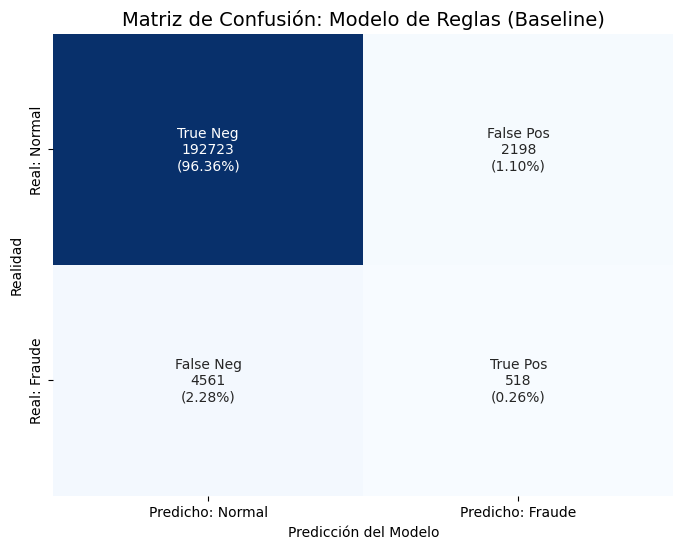

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Usamos las variables que YA calculaste en la celda anterior (tp, tn, fp, fn)
# Creamos una matriz 2x2
matriz_confusion = np.array([[tn, fp], 
                             [fn, tp]])

# Etiquetas para que se entienda
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in matriz_confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matriz_confusion.flatten()/np.sum(matriz_confusion)]

# Combinar texto para ponerlo dentro de los cuadros
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# GRAFICAR
plt.figure(figsize=(8, 6))
sns.heatmap(
    matriz_confusion, 
    annot=labels, 
    fmt='', 
    cmap='Blues', 
    cbar=False,
    xticklabels=['Predicho: Normal', 'Predicho: Fraude'],
    yticklabels=['Real: Normal', 'Real: Fraude']
)

plt.title('Matriz de Confusión: Modelo de Reglas (Baseline)', fontsize=14)
plt.ylabel('Realidad')
plt.xlabel('Predicción del Modelo')
plt.show()

In [ ]:
from pyspark.sql.functions import avg, min, max, stddev

# --- 1. Aislar los Falsos Positivos de la Regla (Inocentes) ---
df_falsos_positivos = df_eval_reglas.filter((col('label') == 0) & (col('prediction') == 1))

print(f"--- Análisis de {fp} Falsos Positivos (Clientes Inocentes Molestados) ---")
df_falsos_positivos.select(
    avg("monto").alias("monto_avg"),
    min("monto").alias("monto_min"),
    max("monto").alias("monto_max"),
    stddev("monto").alias("monto_stddev")
).show()

# --- 2. Aislar los Verdaderos Positivos (Fraudes Reales) ---
df_verdaderos_positivos = df_eval_reglas.filter((col('label') == 1) & (col('prediction') == 1))

print(f"--- Análisis de {tp} Verdaderos Positivos (Fraudes Reales Atrapados) ---")
df_verdaderos_positivos.select(
    avg("monto").alias("monto_avg"),
    min("monto").alias("monto_min"),
    max("monto").alias("monto_max"),
    stddev("monto").alias("monto_stddev")
).show()

--- Análisis de 2198 Falsos Positivos (Clientes Inocentes Molestados) ---
+------------------+---------+---------+-----------------+
|         monto_avg|monto_min|monto_max|     monto_stddev|
+------------------+---------+---------+-----------------+
|1132.7013466787987|   100.12|  4903.97|779.6334064187494|
+------------------+---------+---------+-----------------+

--- Análisis de 518 Verdaderos Positivos (Fraudes Reales Atrapados) ---
+-----------------+---------+---------+------------------+
|        monto_avg|monto_min|monto_max|      monto_stddev|
+-----------------+---------+---------+------------------+
|44133.37916988417|   5000.0|  99998.7|29660.612809257615|
+-----------------+---------+---------+------------------+



--- 1. Histograma: Distribución de Montos (Fraude vs Normal) ---


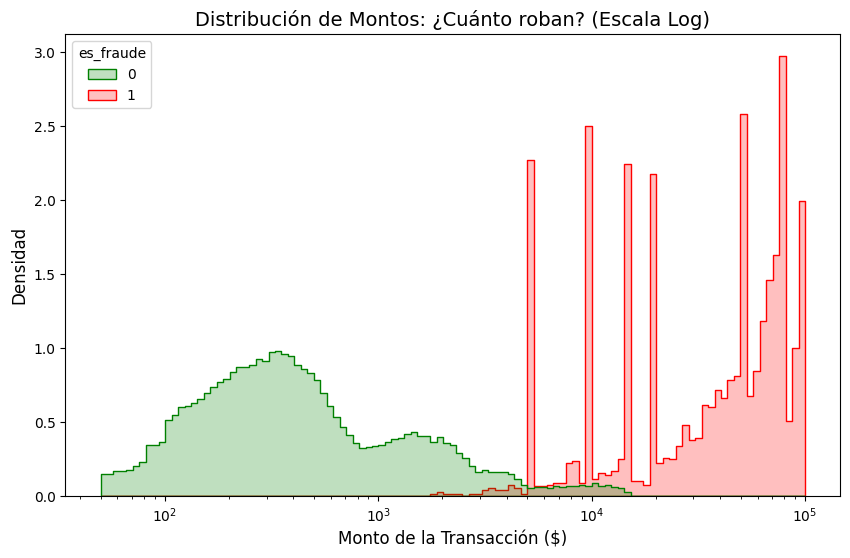

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

print("--- 1. Histograma: Distribución de Montos (Fraude vs Normal) ---")

# 1. Preparar datos
# Tomamos una muestra del 50% para que sea rápido de procesar en Pandas
# Si tu dataset es pequeño, puedes quitar .sample(...)
df_hist_monto = df_limpio.select("monto", "es_fraude").sample(False, 0.5, seed=42)
pdf_monto = df_hist_monto.toPandas()

# 2. Graficar
plt.figure(figsize=(10, 6))

sns.histplot(
    data=pdf_monto,
    x="monto",
    hue="es_fraude",     # Separa colores por fraude
    element="step",      # Dibuja solo el contorno (más limpio)
    stat="density",      # Importante: Normaliza para comparar formas, no cantidades absolutas
    common_norm=False,   # Cada grupo se escala por separado
    log_scale=True,      # ¡Truco clave para datos financieros!
    palette=["green", "red"]
)

plt.title('Distribución de Montos: ¿Cuánto roban? (Escala Log)', fontsize=14)
plt.xlabel('Monto de la Transacción ($)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

--- 2. Histograma: Distribución Horaria (Usando 'hora_movimiento') ---


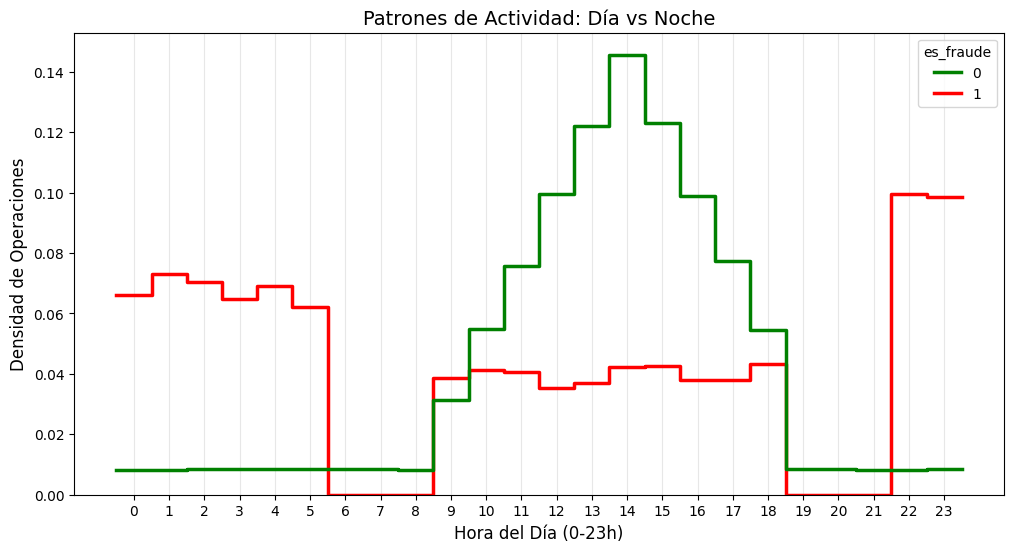

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import hour, col

print("--- 2. Histograma: Distribución Horaria (Usando 'hora_movimiento') ---")

# 1. Extraer la hora directamente de la columna 'hora_movimiento'
# Como ya es tipo 'timestamp' en tu schema, no necesitamos convertirla.
df_hist_hora = df_limpio.withColumn("hora_del_dia", hour(col("hora_movimiento"))) \
                        .select("hora_del_dia", "es_fraude")

# Filtramos nulos por seguridad (aunque al ser timestamp no debería haber problemas graves)
df_hist_hora = df_hist_hora.filter(col("hora_del_dia").isNotNull())

# 2. Convertir a Pandas
pdf_hora = df_hist_hora.toPandas()

# 3. Graficar
if not pdf_hora.empty:
    plt.figure(figsize=(12, 6))

    sns.histplot(
        data=pdf_hora,
        x="hora_del_dia",
        hue="es_fraude",
        multiple="layer",
        stat="density",      # Normaliza para comparar patrones
        common_norm=False,   # Cada grupo suma 100% por separado
        discrete=True,       # Alinea las barras perfectamente en la hora (0, 1, 2...)
        palette=["green", "red"], # Verde=Normal, Rojo=Fraude
        element="step",      # Estilo contorno
        fill=False,          # Sin relleno para ver mejor el cruce
        linewidth=2.5        # Línea gruesa para que se vea bien
    )

    plt.title('Patrones de Actividad: Día vs Noche', fontsize=14)
    plt.xlabel('Hora del Día (0-23h)', fontsize=12)
    plt.ylabel('Densidad de Operaciones', fontsize=12)
    plt.xticks(range(0, 24)) # Mostrar todas las horas del 0 al 23
    plt.grid(axis='x', alpha=0.3)
    plt.show()
else:
    print("❌ Error: El DataFrame sigue vacío. Revisa que 'hora_movimiento' no tenga puros nulos.")

In [ ]:
# Vamos a ver qué columnas tienes y de qué tipo son
df_limpio.printSchema()

# Y vamos a ver una fila de ejemplo para buscar dónde está la hora
df_limpio.show(1, vertical=True, truncate=False)

root
 |-- id_transaccion: integer (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- nombre_cliente: string (nullable = true)
 |-- cuenta_origen: double (nullable = true)
 |-- fecha: string (nullable = true)
 |-- monto: double (nullable = true)
 |-- divisa: string (nullable = true)
 |-- tipo_transaccion: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- cuenta_destino: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- hora_movimiento: timestamp (nullable = true)
 |-- concepto_movimiento: string (nullable = true)
 |-- saldo_previo: double (nullable = true)
 |-- saldo_posterior: double (nullable = true)
 |-- canal_transaccion: string (nullable = true)
 |-- medio_pago: string (nullable = true)
 |-- estatus: string (nullable = true)
 |-- fraude_probable: string (nullable = true)
 |-- es_fraude: integer (nullable = false)

-RECORD 0----------------------------------
 id_transaccion      | 1                   
 id_cliente          | 21952

--- 3. Histograma: Saldo Previo de la Cuenta (Perfil de Víctima) ---


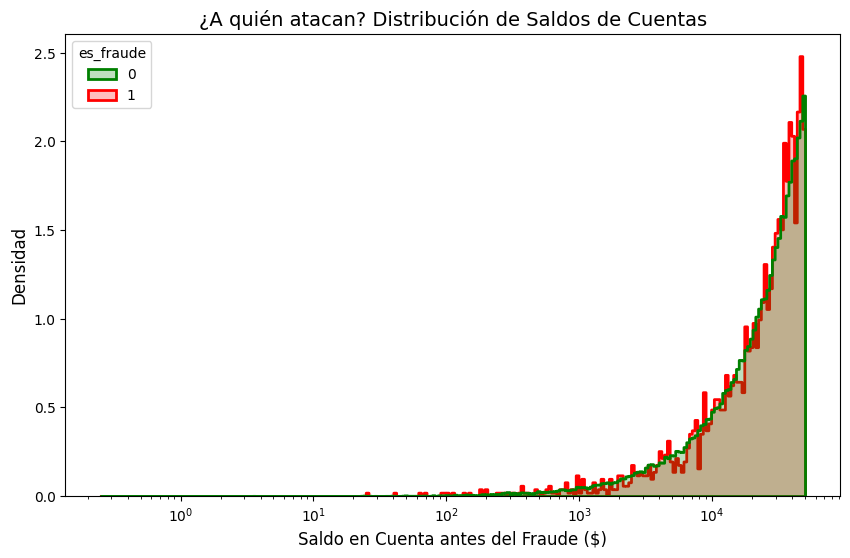

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, log10

print("--- 3. Histograma: Saldo Previo de la Cuenta (Perfil de Víctima) ---")

# 1. Seleccionar datos y filtrar saldos en 0 para evitar error en log
# (A veces las cuentas origen tienen saldo 0 en ciertos tipos de fraude)
df_saldo = df_limpio.select("saldo_previo", "es_fraude") \
                    .filter(col("saldo_previo") > 0)

# 2. Convertir a Pandas
pdf_saldo = df_saldo.sample(False, 0.5, seed=42).toPandas()

# 3. Graficar
plt.figure(figsize=(10, 6))

sns.histplot(
    data=pdf_saldo,
    x="saldo_previo",
    hue="es_fraude",
    element="step",
    stat="density",
    common_norm=False,
    log_scale=True,       # Clave para ver rangos de dinero
    palette=["green", "red"],
    linewidth=2
)

plt.title('¿A quién atacan? Distribución de Saldos de Cuentas', fontsize=14)
plt.xlabel('Saldo en Cuenta antes del Fraude ($)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.show()

--- 4. Histograma: ¿Qué porcentaje de la cuenta se llevaron? ---


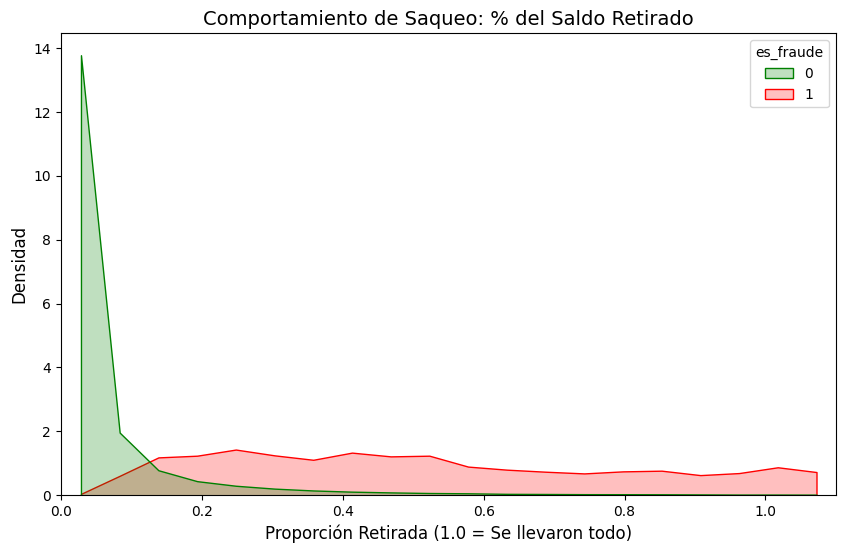

In [ ]:
from pyspark.sql.functions import col, when

print("--- 4. Histograma: ¿Qué porcentaje de la cuenta se llevaron? ---")

# 1. Calcular el Ratio: (Monto / Saldo Previo)
# Si el saldo es 0, ponemos 0 para evitar divisiones por cero
df_ratio = df_limpio.withColumn("ratio_retiro", 
    when(col("saldo_previo") > 0, col("monto") / col("saldo_previo")).otherwise(0)
)

# Filtramos ratios locos (a veces por error de datos el ratio es 1000%)
# Nos interesa ver del 0 al 1 (0% al 100% de la cuenta)
df_ratio = df_ratio.filter((col("ratio_retiro") <= 1.1) & (col("ratio_retiro") > 0)) \
                   .select("ratio_retiro", "es_fraude")

# 2. Convertir a Pandas
pdf_ratio = df_ratio.toPandas()

# 3. Graficar
plt.figure(figsize=(10, 6))

sns.histplot(
    data=pdf_ratio,
    x="ratio_retiro",
    hue="es_fraude",
    element="poly",      # Usamos 'poly' para ver áreas rellenas, se ve muy bien aquí
    stat="density",
    common_norm=False,
    bins=20,             # 20 barras (cada una representa un 5%)
    palette=["green", "red"]
)

plt.title('Comportamiento de Saqueo: % del Saldo Retirado', fontsize=14)
plt.xlabel('Proporción Retirada (1.0 = Se llevaron todo)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.xlim(0, 1.1)
plt.show()

--- Histograma de Log(Monto) con KDE ---


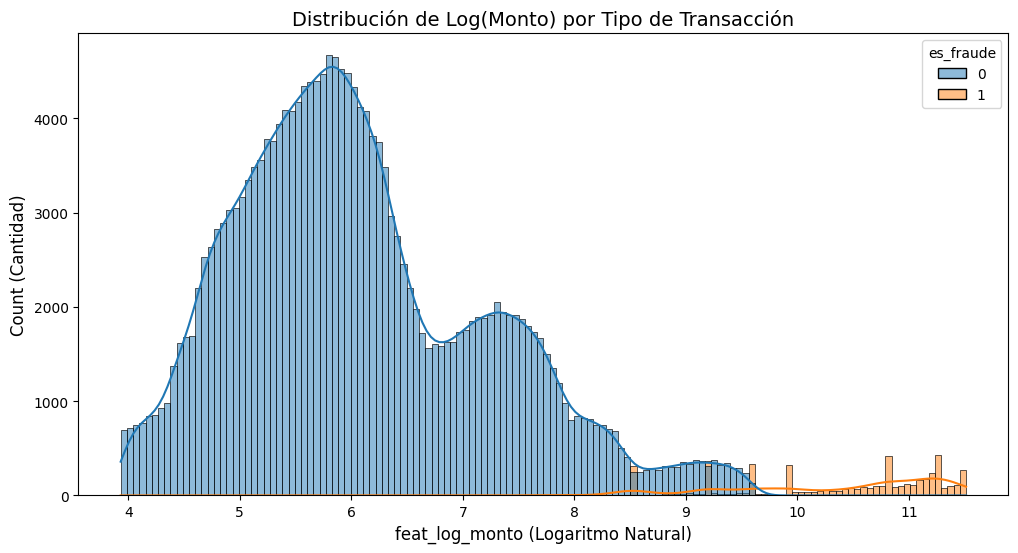

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, log

print("--- Histograma de Log(Monto) con KDE ---")

# 1. Feature Engineering: Calcular el Logaritmo Natural del Monto
# Sumamos +1 dentro del logaritmo para evitar errores matemáticos si el monto es 0 (log(0) es infinito)
df_log_monto = df_limpio.withColumn("feat_log_monto", log(col("monto") + 1)) \
                        .select("feat_log_monto", "es_fraude")

# 2. Convertir a Pandas
pdf_log_monto = df_log_monto.toPandas()

# 3. Graficar
plt.figure(figsize=(12, 6))

sns.histplot(
    data=pdf_log_monto,
    x="feat_log_monto",
    hue="es_fraude",
    kde=True,            # <--- ESTO agrega la línea curva suave sobre las barras
    element="bars",      # Dibuja barras tradicionales
    stat="count",        # El eje Y muestra la cantidad de registros
    common_norm=False,   # No normalizar, mostrar conteos reales (o densidades separadas)
    palette="tab10",     # Usa la paleta Azul/Naranja clásica de tu imagen
    alpha=0.5            # Transparencia para ver dónde se cruzan
)

plt.title('Distribución de Log(Monto) por Tipo de Transacción', fontsize=14)
plt.xlabel('feat_log_monto (Logaritmo Natural)', fontsize=12)
plt.ylabel('Count (Cantidad)', fontsize=12)

plt.show()

In [ ]:
# %%
from pyspark.sql.functions import col, when, hour, avg, log, to_date

# --- 0. CORRECCIÓN APLICADA AQUÍ ---
# Le decimos a 'to_date' que el formato es 'día/mes/año'
df_con_tiempo = df_limpio.withColumn("fecha_dt", to_date(col("fecha"), "dd/MM/yyyy")) \
                         .withColumn("hora_del_dia", hour(col("hora_movimiento")))

# --- 1. Crear Banderas de Riesgo ---
df_features = df_con_tiempo.withColumn("feat_horario_riesgo", 
    when(col("hora_del_dia").between(0, 4), 1).otherwise(0)
).withColumn("feat_tipo_riesgo", 
    when(col("tipo_transaccion").isin("Transferencia", "Transferencia internacional"), 1).otherwise(0)
).withColumn("feat_canal_riesgo", 
    when(col("canal_transaccion").isin("Sucursal bancaria", "Web", "App movil"), 1).otherwise(0)
)

# --- 2. Crear "Golden Feature" (Interacción) ---
df_features = df_features.withColumn("feat_perfil_riesgo_completo", 
    when((col("feat_horario_riesgo") == 1) & 
         (col("feat_tipo_riesgo") == 1) & 
         (col("feat_canal_riesgo") == 1), 1).otherwise(0)
)

# --- 3. Features de Monto (Log y Ratio) ---
df_features = df_features.withColumn("feat_log_monto", log(col("monto") + 1))

# 3.1 Calcular promedios por tipo
promedios_tipo = df_features.groupBy("tipo_transaccion") \
    .agg(avg("monto").alias("monto_promedio_tipo"))

# 3.2 Unir (join) los promedios
df_features = df_features.join(promedios_tipo, on="tipo_transaccion", how="left")

# 3.3 Crear el ratio
df_features = df_features.withColumn("feat_ratio_monto_vs_tipo", 
    when(col("monto_promedio_tipo") > 0, col("monto") / col("monto_promedio_tipo")) \
    .otherwise(0)
)

print("DataFrame 'df_features' re-creado con la corrección de fecha.")

DataFrame 'df_features' re-creado con la corrección de fecha.


In [ ]:
# %%
# Este código no cambia, pero ahora funcionará
ruta_escritura_features = "/home/zidnz/DanaPP/proyecto_fraude/delta_lake_features"

print(f"Guardando el DataFrame con features en: {ruta_escritura_features}")

df_features.write \
    .format("delta") \
    .mode("overwrite") \
    .save(ruta_escritura_features)

print("¡Tabla de features guardada con éxito!")

Guardando el DataFrame con features en: /home/zidnz/DanaPP/proyecto_fraude/delta_lake_features


25/11/17 14:47:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


¡Tabla de features guardada con éxito!
